<a href="https://colab.research.google.com/github/JairEsc/Mat_Apl_2/blob/main/Epid_MCMC_covid.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [20]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats

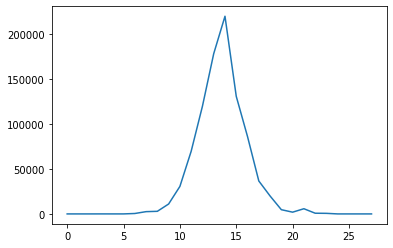

In [21]:
datos=pd.read_csv("SEIR.csv",sep=';')
plt.plot(datos['incidencia'])
Ydat=datos['incidencia']

In [22]:
par1=[2.5,0,0.3]  #hiperpar'ametros para beta
par2=[5,0,0.3]  #hiperpar'ametros para lamba
par3=[1.2,0,0.5]  #hiperpar'ametros para gamma

def logaprioris(theta):
    be,la,ga = theta
    dbe = scipy.stats.gamma.logpdf(be,par1[0],par1[1],par1[2])
    dla = scipy.stats.gamma.logpdf(la,par2[0],par2[1],par2[2])
    dga = scipy.stats.gamma.logpdf(ga,par3[0],par3[1],par3[2])
    return(dbe+dla+dga)


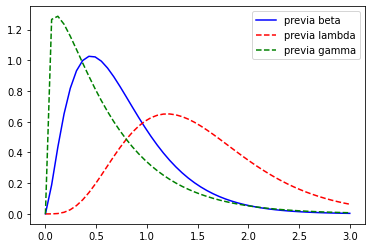

In [23]:
par1=[2.5,0,0.3]  #hiperpar'ametros para beta
par2=[5,0,0.3]  #hiperpar'ametros para lamba
par3=[1.2,0,0.5]  #hiperpar'ametros para gamma
x = np.linspace(0., 3., 50)
prev1 = scipy.stats.gamma.pdf(x, par1[0],par1[1],par1[2])
prev2 = scipy.stats.gamma.pdf(x, par2[0],par2[1],par2[2])
prev3 = scipy.stats.gamma.pdf(x, par3[0],par3[1],par3[2])
plt.plot(x, prev1, 'b-', label='previa beta')
plt.plot(x, prev2, 'r--', label='previa lambda')
plt.plot(x, prev3, 'g--', label='previa gamma')
plt.legend(loc="best")


In [24]:
#### verosimilitud
def logverosimilitud(theta):
  be,la,ga = theta
  dias = 100
  t = np.linspace(0,100,101)  ## vector de tiempos
  Xt =  odeint(func=SEIR, y0=X0, t=t, args=(N,be,la,ga))
  ### Incidencia
  Inc = np.diff(Xt[:,3])
  vers = scipy.stats.poisson.logpmf(Ydat, Inc)
  ver = np.sum(vers)
  return(ver)  

#### Posterior
def logposterior(theta):
  return(logaprioris(theta)+logverosimilitud(theta))


In [25]:
def posterior(theta):
    return(np.exp(logaprioris(theta)+logverosimilitud(theta)))

In [26]:
def vectoriza(fun,lp,up,i,j,m):
  ## i,j son las entradas del vector de parám.
  ## de los parámetros que se van a graficar
  xx = np.linspace(lp[0],up[0],m)
  yy = np.linspace(lp[1],up[1],m)
  xx,yy = np.meshgrid(xx,yy)
  z = np.zeros([m,m])
  temp = par_dat.copy()
  ## los demás entrarán como parámetros
  for u in range(m):
    for v in range(m):
      temp[i] = xx[u][v]
      temp[j] = yy[u][v]
      z[u][v] = fun(temp)
  return(xx,yy,z)

In [27]:
# Genera las propuestas
def rkernelprop(present, sd, size=1):
    myclip_a = 0
    myclip_b = 1e10
    a, b = (myclip_a - present) / sd, (myclip_b - present) / sd
    proposal = truncnorm.rvs(a,b,loc = present, scale = sd, size=size)
    return(proposal)

# Reporta la densidad de la propuesta    
def dkernelprop(prop,present,sd):
    myclip_a = 0
    myclip_b = 1e10
    a, b = (myclip_a - present) /sd, (myclip_b - present) / sd
    denproposal = truncnorm.pdf(prop, a, b, loc = present, scale = sd)
    return(denproposal)  

In [28]:
sims = rkernelprop(present = 1.1, sd = 1, size = 1000)
plt.hist(sims, 14 , density = True,  histtype ='bar', 
         color ='orange', alpha = 0.6)
x = np.linspace(0., 5., 50)
plt.plot(x, dkernelprop(x,1.1,1), '--')


NameError: ignored

In [ ]:
sims = rkernelprop(present = 0.5, sd = 0.01, size = 1000)
plt.hist(sims, 14 , density = True,  histtype ='bar', 
         color ='orange', alpha = 0.6)
x = np.linspace(.4, .6, 50)
plt.plot(x, dkernelprop(x,0.5,0.01), '--')

In [ ]:
def inicializa():
  flag=False
  while flag==False:
    a = scipy.stats.gamma.rvs(par1[0],par1[1],par1[2])
    b = scipy.stats.gamma.rvs(par2[0],par2[1],par2[2])    
    c = scipy.stats.gamma.rvs(par3[0],par3[1],par3[2])
    tt = np.array([a, b, c])
    print("entra")
    if posterior(tt)>0:
      theta_ini = tt
      flag=True
  return(theta_ini)


In [ ]:
def MH(iters, theta_ini, sd):
    theta_act = theta_ini

    be_v = np.zeros(iters)          ## guardar cadenas de betas
    la_v = np.zeros(iters)          ##guardar cadenas de lambdas
    ga_v = np.zeros(iters)          ##guardar cadenas de gammas
    logposter_v = np.empty(iters)   ##guardar todas las posteriores
    
    ### primer entrada de cada cadena
    logposter_v[0] = logposterior(theta_act)
    theta_prop = [0., 0. , 0.]
    actualizo = 0

    for i in range(1,iters):
        ### empieza propuesta
        theta_prop[0] = rkernelprop(present = theta_act[0], sd = sd, size=1)[0]
        theta_prop[1] = rkernelprop(present = theta_act[1], sd = sd, size=1)[0]
        theta_prop[2] = rkernelprop(present = theta_act[2], sd = sd, size=1)[0]
        #print(theta_prop)

        # alfa
        qxy = dkernelprop(theta_act[0], theta_prop[0],sd) * dkernelprop(theta_act[1], theta_prop[1],sd) * dkernelprop(theta_act[2],theta_prop[2],sd)  #centrada en propuesto
        qyx = dkernelprop(theta_prop[0],theta_act[0],sd) * dkernelprop(theta_prop[1],theta_act[1],sd) * dkernelprop(theta_prop[2],theta_act[2],sd)    #centrada en actual
    
        lognum = logposterior(theta_prop)+np.log(qxy)
        logden = logposterior(theta_act)+np.log(qyx)
        razon = np.exp(lognum - logden)
        A = min(1,razon)
        #print(A)
        #print(posterior(theta_prop), posterior(theta_act))

        if np.random.uniform(0,1,1)<A: # actualiza
          be_v[i] = theta_prop[0]
          la_v[i] = theta_prop[1]   
          ga_v[i] = theta_prop[2]
          logposter_v[i] = logposterior(theta_prop)
          theta_act = theta_prop.copy()
          actualizo += 1
        else: # no actualiza
          be_v[i] = theta_act[0]
          la_v[i] = theta_act[1]   
          ga_v[i] = theta_act[2]
          logposter_v[i] = logposterior(theta_act)

    rechazo = iters-actualizo        
    theta = np.array([be_v, la_v, ga_v])
    return(theta, logposter_v, rechazo, actualizo)


In [ ]:
np.random.seed(478) 
iters = 10000

sims, logpost, rechazo, actualizo= MH(iters=iters, theta_ini = tt, sd=0.01)
%timeit sims
print('rechazó: ',rechazo)
print('actualizó: ',actualizo)

In [ ]:
sims.shape
for i in range(3):
  plt.plot(sims[i,:])

In [ ]:
fig, ax = plt.subplots(3,1)
for i in range(3):
  ax[i].plot(sims[i,2000:iters])

In [ ]:
fig = plt.figure(figsize=(20, 10)) # create the canvas for plotting
ax1 = plt.subplot(3,1,1) # (2,1,1) indicates total number of rows, columns, and figure number respectively
ax1.plot(sims[0,2000:iters])
ax2 = plt.subplot(3,1,2)
ax2.plot(sims[1,2000:iters])
ax3 = plt.subplot(3,1,3)
ax3.plot(sims[2,2000:iters])

In [ ]:
plot_acf(sims[0,:].tolist(), lags=50);
plot_acf(sims[1,:].tolist(), lags=50);
plot_acf(sims[2,:].tolist(), lags=50);

In [ ]:
fig = plt.figure(figsize=(10, 10)) # create the canvas for plotting

x1 = plt.subplot(3,1,1)
plt.hist(sims[0,:], 14 , density = True,  histtype ='bar',  color ='orange', alpha = 0.6);
plt.axvline(x = theta_real[0] , color = 'b')
          
ax2 = plt.subplot(3,1,2)
plt.hist(sims[1,:], 14 , density = True,  histtype ='bar', color ='orange', alpha = 0.6);
plt.axvline(x = theta_real[1] , color = 'b')

ax3 = plt.subplot(3,1,3)
plt.hist(sims[2,:], 14 , density = True,  histtype ='bar', color ='orange', alpha = 0.6)
plt.axvline(x = theta_real[2] , color = 'b')

In [ ]:
print("Beta:   ", mquantiles(sims[0,:], prob=[0.025, 0.5, 0.975]))
print("Lambda: ",mquantiles(sims[1,:], prob=[0.025, 0.5, 0.975]))
print("Gamma:  ",mquantiles(sims[2,:], prob=[0.025, 0.5, 0.975]))
print("")
print("Verdaderos valores: ", theta_real)

In [ ]:
curvas_aceptadas = np.zeros([8000,100])
j=0
for i in range(2000,iters):
	solucion =  odeint(func=SEIR, y0=X0, t=np.linspace(0,100,101), args=(N,sims[0,i], sims[1,i], sims[2,i]))
	Y = solucion.T[3,:]
	curvas_aceptadas[j,:] = Y[1:]-Y[:-1]
	j +=1

In [ ]:
plt.figure(figsize=(15, 8))
for i in range(8000):
  plt.plot(np.linspace(0, 100, 100),curvas_aceptadas[i,:],color="grey",alpha=0.5)
plt.plot(np.linspace(0, 100, 100),data)
plt.plot(np.linspace(0, 100, 100),Ydat)
#plt.plot(np.linspace(0, 100, 100),curvas_aceptadas[900,:],color="red",alpha=0.5)